In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

2025-10-21 12:24:10.233964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761049450.452870      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761049450.508732      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Oxford-IIIT Pet dataset

In [2]:
# Load Oxford-IIIT pet dataset
(train_ds, val_ds), info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', "train[80%:]"],
    with_info = True,
    as_supervised = True
)

NUM_CLASSES = info.features['label'].num_classes
print(f"Number of classes in Oxford-IIIT Pet dataset is {NUM_CLASSES}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1761049553.026035      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761049553.026804      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.ALVTAO_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.ALVTAO_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
Number of classes in Oxford-IIIT Pet dataset is 37


In [3]:
def preprocess(image, label):
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32)
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds  = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)

In [4]:
# Data augnentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [5]:
# Load the ResNet50V2 model without the top layer
res_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224 ,224, 3))
res_model.trainable = True

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
    )

es = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

## Finetune the layers of resnet

In [8]:
# Add custom top layers
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)

x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = res_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Final model
model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [9]:
model.compile(optimizer=Adam(1e-5), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=40,
    callbacks=[es, lr]
)

Epoch 1/40


I0000 00:00:1761049663.639312     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


46/46 ━━━━━━━━━━━━━━━━━━━━ 96s 937ms/step - accuracy: 0.0359 - loss: 4.0046 - val_accuracy: 0.0530 - val_loss: 3.6670 - learning_rate: 1.0000e-05
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 877ms/step - accuracy: 0.0476 - loss: 3.7129 - val_accuracy: 0.1413 - val_loss: 3.2800 - learning_rate: 1.0000e-05
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 863ms/step - accuracy: 0.1027 - loss: 3.4315 - val_accuracy: 0.2500 - val_loss: 2.9561 - learning_rate: 1.0000e-05
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 873ms/step - accuracy: 0.1535 - loss: 3.1677 - val_accuracy: 0.3736 - val_loss: 2.6054 - learning_rate: 1.0000e-05
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 871ms/step - accuracy: 0.2439 - loss: 2.8865 - val_accuracy: 0.5190 - val_loss: 2.2120 - learning_rate: 1.0000e-05
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 871ms/step - accuracy: 0.3251 - loss: 2.6053 - val_accuracy: 0.6250 - val_loss: 1.8411 - learning_rate: 1.0000e-05
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 872ms/step - accuracy: 0.41

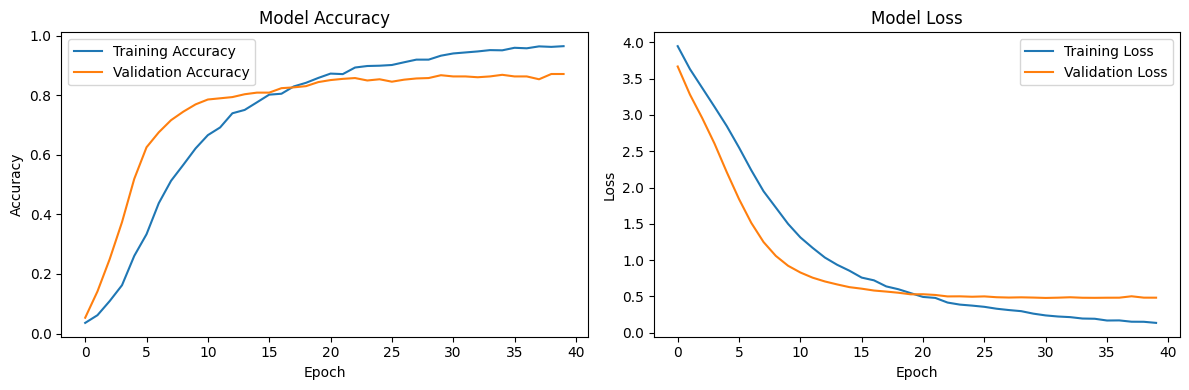

In [10]:
# Plot training & validation accuracy, loss values
history = model.history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy values
ax1.plot(history['accuracy'], label='Training Accuracy')
ax1.plot(history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss values
ax2.plot(history['loss'], label='Training Loss')
ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.savefig('/kaggle/working/accuracy_loss_plot2.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [11]:
# Retrieve best metrics
best_train_acc = max(history['accuracy'])
best_val_acc = max(history['val_accuracy'])
print(f"Best training accuracy is {(best_train_acc * 100):.2f}%")
print(f"Best validation accuracy is {(best_val_acc * 100):.2f}%")

Best training accuracy is 96.43%
Best validation accuracy is 87.09%
